In [855]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
%matplotlib inline
import warnings
from sklearn.feature_selection import RFECV

warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a'
    )

In [856]:
raw = pd.read_csv('epi_r.csv')# read data
raw = raw.drop(['calories', 'protein', 'fat', 'sodium','title'],1)#drop nulls/non-numeric
raw.rating = np.where(raw.rating>4,1,0)#convert rating to binary at 4+
raw.columns = raw.columns.str.replace('[^a-zA-Z]', '')#replace space,non-alpha
_, i = np.unique(raw.columns, return_index=True)#list unique columns
raw = raw.iloc[:, i]#select unique columns

In [857]:
cols = []
usage = []
#append attribute names and the percentage used in the data
for col in raw.select_dtypes(include=['float64']):
    cols.append(col)
    usage.append(raw[col].mean())
#pop the 'rating' entry out for plotting purposes'
cols.pop(0)
usage.pop(0)

ingreds = pd.DataFrame(
    sorted(zip(map(lambda x: round(x, 4), usage), 
               cols), reverse=True))
ingreds[0] = ingreds[0]*100

common = ingreds[ingreds[0]>20]

plotdf = raw.copy()
plotdf.rating = np.where(plotdf['rating']>4,1,0)
'''for col in common[1]:   
    pdf = pd.DataFrame()
    pdf["g_att"] = plotdf.loc[plotdf[col]==1][col]
    pdf['rate'] = plotdf.loc[plotdf[col]==1]['rating']
    g = plt.figure(figsize=(9,6))
    g = sns.barplot(y=plotdf[col],x=plotdf['rating'],palette='Blues_d')
    plt.title('Rating Distribution, {}'.format(col))
    plt.show()'''

'for col in common[1]:   \n    pdf = pd.DataFrame()\n    pdf["g_att"] = plotdf.loc[plotdf[col]==1][col]\n    pdf[\'rate\'] = plotdf.loc[plotdf[col]==1][\'rating\']\n    g = plt.figure(figsize=(9,6))\n    g = sns.barplot(y=plotdf[col],x=plotdf[\'rating\'],palette=\'Blues_d\')\n    plt.title(\'Rating Distribution, {}\'.format(col))\n    plt.show()'

In [858]:
#create lists for some attribute examination.
#For each, attribute I will find out how often it occurs, what the odds are of it being a '0' recipe, 
#and of the number of occurances, what it the probabilty that it is a 1.
cols = []
odds_of_zero = []
present = []
pct_good = []
variance = []


#loop to compare the odds of getting rating = 0 vs rating 1
for col in raw.loc[:, ~(raw.columns).isin(['rating'])]:
    variance.append(raw[col].mean())
    odds = raw.loc[raw[col]==1] #locate entries where attribute value is 1
    cols.append(col)#append the attribute name
    present.append(len(odds.rating))#the occurance of attribute
    pct_good.append(odds.rating.mean())#percent good recipes when attribute present
    #in the case of zero occurance of good ratings
    if odds.rating.sum() == 0:
        odds_of_zero.append(100)
    # if sum() not 0, calculate odds.
    if odds.rating.sum() != 0:
        that = len(odds.rating)-odds.rating.sum()
        this = odds.rating.sum()
        odds_of_zero.append(that/this)
    

In [859]:
pdf = pd.DataFrame()
pdf['col'] = cols
pdf['odds_of_zero'] = odds_of_zero
pdf['present'] = present
pdf['variance'] = variance
pdf['pct_good'] = pct_good

In [860]:
pdf.head()

,col,odds_of_zero,present,variance,pct_good
0,advancepreprequired,1.096154,109,0.005436,0.477064
1,alabama,2.000000,3,0.000150,0.333333
2,alaska,100.000000,2,0.000100,0.000000
3,alcoholic,1.849829,835,0.041642,0.350898
4,almond,0.654391,584,0.029124,0.604452


(672, 672)


C:\Users\willd\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


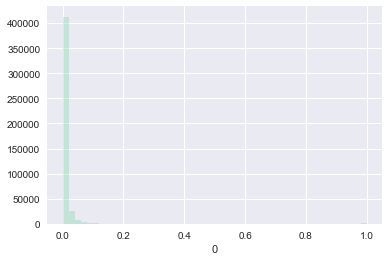

,level_0,level_1,0
0,advancepreprequired,advancepreprequired,1.0
148733,frittata,frittata,1.0
154117,georgia,georgia,1.0
153444,garlic,garlic,1.0
152771,game,game,1.0
152098,fry,fry,1.0
151425,fruitjuice,fruitjuice,1.0
150752,fruit,fruit,1.0
150079,frozendessert,frozendessert,1.0
149406,fritter,fritter,1.0


In [861]:
corrmat = raw.drop(['rating'],1).corr().abs()#create correlation matrix
print(corrmat.shape)
c = corrmat.unstack().reset_index()
#take a look at the distribution of the higher correlated pairs.

#plot a histogram
fig = sns.distplot(c[0],kde=False,bins=50)
plt.show()
c.sort_values(by=0,ascending=False).head(15)

C:\Users\willd\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


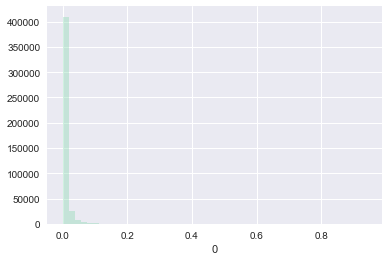

In [862]:
d = c.loc[(c[0]!=1)&(c[0]>.40)]
e = c[c[0] != 1]
fig = sns.distplot(e[0],kde=False,bins=50)
plt.show()

In [863]:
d = d.rename(columns={0:'corr'})
e = e.rename(columns={0:'corr'})

In [864]:
corrgroup = d.groupby('level_0')['level_1'].value_counts()
pdf['n_corrs>.40'] = corrgroup.groupby('level_0').describe().reset_index()['count']
corrgroup = d.groupby('level_0')['level_1'].value_counts()
pdf['avg_corr'] = d.groupby('level_0')['corr'].mean().reset_index()['corr']
pdf.fillna(0,inplace=True)


pdf.head(100)

,col,odds_of_zero,present,variance,pct_good,n_corrs>.40,avg_corr
0,advancepreprequired,1.096154,109,0.005436,0.477064,6.0,0.550141
1,alabama,2.000000,3,0.000150,0.333333,1.0,0.499950
2,alaska,100.000000,2,0.000100,0.000000,1.0,0.591416
3,alcoholic,1.849829,835,0.041642,0.350898,2.0,0.532399
4,almond,0.654391,584,0.029124,0.604452,1.0,0.658596
5,amaretto,0.560000,39,0.001945,0.641026,1.0,0.712295
6,anchovy,0.800000,45,0.002244,0.555556,1.0,0.712295
7,anise,1.071429,116,0.005785,0.482759,1.0,0.707089
8,anniversary,0.761905,111,0.005536,0.567568,1.0,0.707036
9,anthonybourdain,100.000000,2,0.000100,0.000000,1.0,0.424484


In [865]:
x = d.groupby('level_0')['level_1'].unique().reset_index()
print(x)
y = corrgroup.groupby('level_0').describe().reset_index()[['level_0','count']]
print(y)

                 level_0                                            level_1
0              alcoholic  [cocktail, cocktailparty, drink, gin, housegar...
1        anthonybourdain                                         [meatloaf]
2                atlanta                                          [georgia]
3            backyardbbq                             [grill, grillbarbecue]
4              bonapptit                                          [gourmet]
5              breakfast                                           [brunch]
6                 brunch                                        [breakfast]
7                 caviar                                      [potatosalad]
8                chicago                                         [illinois]
9                chicken                                          [poultry]
10             christmas                                     [christmaseve]
11          christmaseve                                        [christmas]
12          

In [866]:
correlates = []
above75 = []
avgcorr = []
#corrmat = raw.corr()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


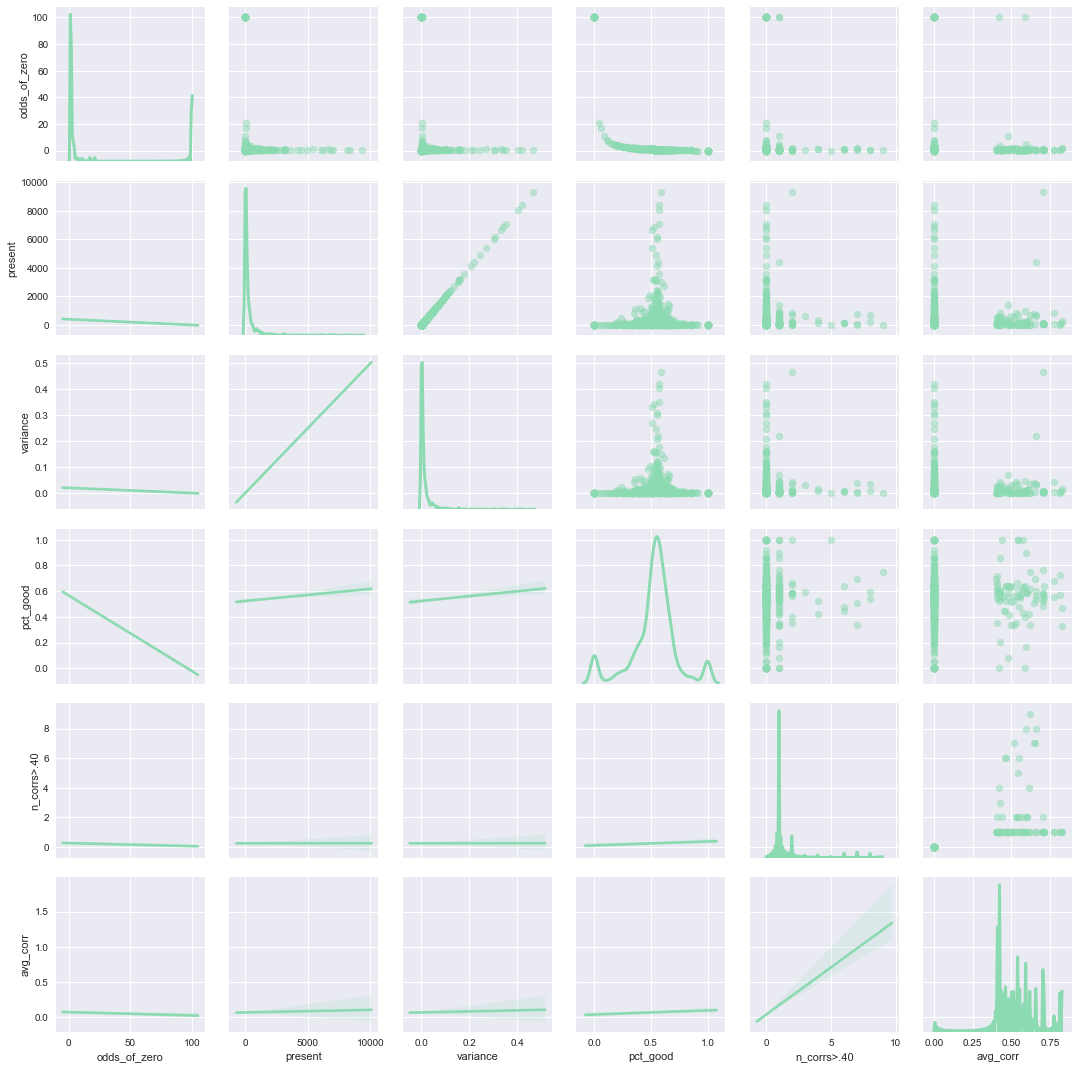

In [867]:
#A quick visuaization,
sns.set_style('darkgrid')
g = sns.PairGrid(pdf, diag_sharey=False)

g.map_upper(plt.scatter, alpha=.5)

g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

g.map_diag(sns.kdeplot, lw=3)
plt.show()

The pair plot sheds some light on could be happening in the data.
note, that all observations of '100' in 'odds_of_zero' were forced to 0
and represent the observation where all of the recipes in which the atribute was prsent had a rating of 0.
ie '#observations/0' (good recipes) ~ n/0 = -inf, these cases should be examined more closely. 
The plots that stand out here are scatter between pct good and odds of zero and the density distribution of pct good.
All of points at 100 on the prior correspond the peak at 0 in the latter.
The smooth curve between the odds and pct_good shouldnt be a surprise as they are function of the same data.
We can make some adjustments and replot the two

C:\Users\willd\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


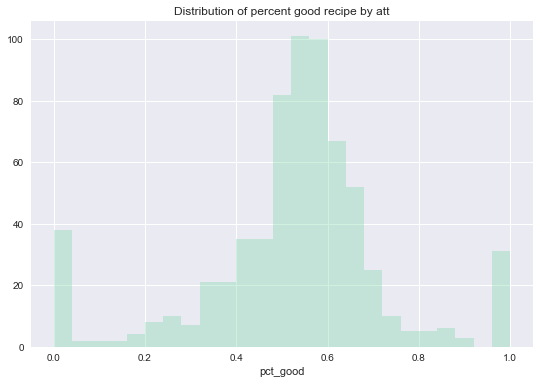

<Figure size 648x432 with 0 Axes>

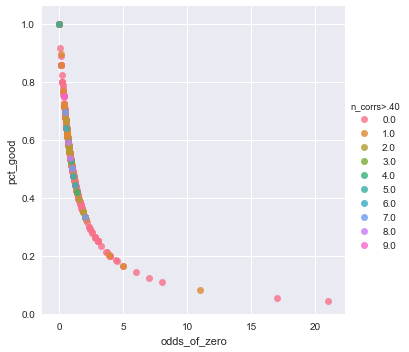

<Figure size 648x432 with 0 Axes>

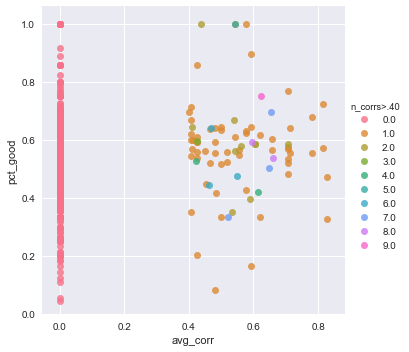

In [868]:
oscat = pdf[pdf.odds_of_zero != 100]

g = plt.figure(figsize=(9,6))
sns.distplot(pdf['pct_good'],bins=25,kde=False)
plt.title("Distribution of percent good recipe by att")
plt.show()

#this historgram is showing us that are particular attributes that are unique to the respective rating classes 

g = plt.figure(figsize=(9,6))
sns.lmplot(x='odds_of_zero',y='pct_good',hue='n_corrs>.40', data=oscat,fit_reg=False)
plt.show()

g = plt.figure(figsize=(9,6))
sns.lmplot(x='avg_corr',y='pct_good',hue='n_corrs>.40',data=oscat,fit_reg=False)

#sns.regplot(x='odds_of_zero',y='pct_good',data=oscat,ax=axes[0, 1]).set_title("Pct good vs odds of 0")


In [869]:
wow = oscat['pct_good']
wow = [(1 - x) for x in wow]
oscat['pct_bad'] = wow

C:\Users\willd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


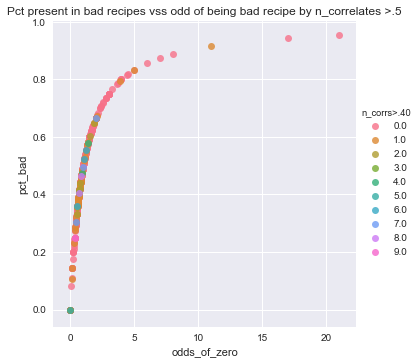

In [870]:

g =sns.lmplot(x='odds_of_zero',y='pct_bad',hue='n_corrs>.40', data=oscat,fit_reg=False)
plt.title('Pct present in bad recipes vss odd of being bad recipe by n_correlates >.5')


plt.show()

In [871]:
always_good = pdf[pdf.pct_good==1]
always_bad = pdf[pdf.pct_good==0]

C:\Users\willd\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


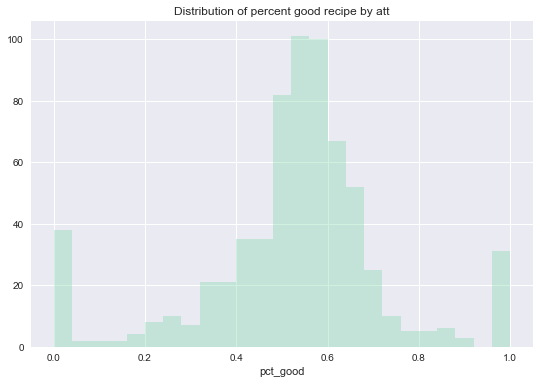

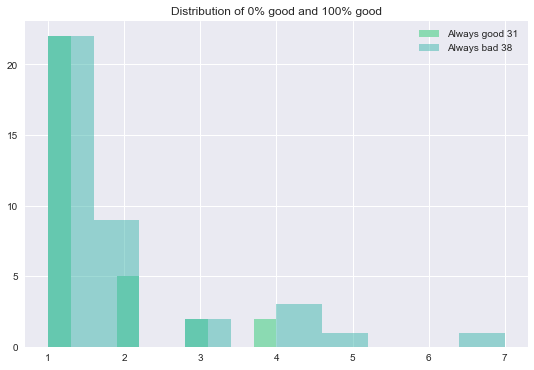

In [872]:
g = plt.figure(figsize=(9,6))
sns.distplot(pdf['pct_good'],bins=25,kde=False)
plt.title("Distribution of percent good recipe by att")
plt.show()

plt.figure(figsize=(9,6))
plt.hist(always_good.present, alpha=1, label="Always good {}".format(len(always_good.present)))
plt.hist(always_bad.present,  alpha=.5, label='Always bad {}'.format(len(always_bad.present)))
plt.title("Distribution of 0% good and 100% good")
plt.legend(loc='upper right')
plt.show()

These attribute will be dropped first because 1. they dont show up frequently enough in the data, and the attribute variance is 0 (only one value is present), these attributes have little impact on a model, other add noise.

In [873]:
pdf = pdf[~pdf['col'].isin(always_good.col)]
pdf = pdf[~pdf['col'].isin(always_bad.col)]

In [874]:
len(pdf.col)

603

C:\Users\willd\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


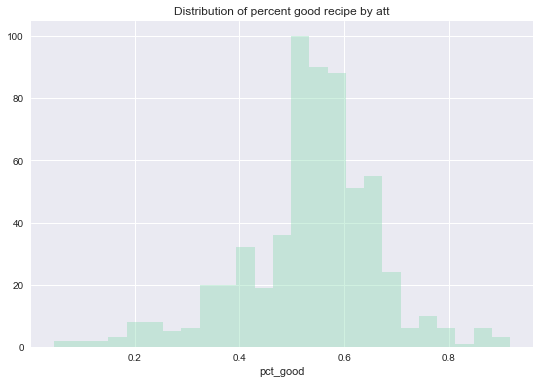

In [875]:
g = plt.figure(figsize=(9,6))
sns.distplot(pdf['pct_good'],bins=25,kde=False)
plt.title("Distribution of percent good recipe by att")
plt.show()

In [883]:
pdf.head()

,col,odds_of_zero,present,variance,pct_good,n_corrs>.40,avg_corr
0,advancepreprequired,1.096154,109,0.005436,0.477064,6.0,0.550141
1,alabama,2.000000,3,0.000150,0.333333,1.0,0.499950
3,alcoholic,1.849829,835,0.041642,0.350898,2.0,0.532399
4,almond,0.654391,584,0.029124,0.604452,1.0,0.658596
5,amaretto,0.560000,39,0.001945,0.641026,1.0,0.712295


In [884]:
# now that the zero variance attributes are gone, lets look closer at the lower variance attributes
good = pdf.loc[((pdf['pct_good']>.80))]
bad = pdf.loc[((pdf['pct_good']<.20))]
lower_var = pd.concat([good,bad])
lower_var_corrmat = raw[lower_var.col].corr()

In [888]:
c = lower_var_corrmat.unstack().reset_index()
d = c.loc[(c[0]!=1)&(c[0]>.01)]
#take a look at the distribution of the higher correlated pairs 
#plot a histogram
d.sort_values(by=0,ascending=False).head(50)

,level_0,level_1,0
337,ingredientrecipes,salsa,0.077997
356,salsa,ingredientrecipes,0.077997
379,scotch,vermouth,0.063559
398,vermouth,scotch,0.063559
28,brisket,sukkot,0.042260
161,sukkot,brisket,0.042260


In [894]:
drinks = raw.loc[(raw.drink==1)]
rating = drinks.rating
drinks = drinks[list(lower_var.col)]
drinks['rating'] = rating 
gooddrinks = drinks.loc[drinks.rating==1]
gooddrinks = gooddrinks[list(lower_var.col)]
baddrinks = drinks.loc[drinks.rating==0]


In [895]:
good_corr = gooddrinks.corr()
bad_corr = baddrinks.corr()

In [913]:
good_corr.fillna(0)
goodl =[]
for i in good_corr:
    goodl.append(good_corr[i].mean())
good2 = [ good_corr[x].mean()for x in good_corr]

In [915]:
good2

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.24782696166841148,
 nan,
 0.24782696166841148,
 0.24729767889836435,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.2478269616684115]

In [916]:
c = good_corr.unstack().reset_index()
d = c.loc[(c[0]!=1)&(c[0]>.01)]
#take a look at the distribution of the higher correlated pairs.

#plot a histogram
d.sort_values(by=0,ascending=False).head(50)

,level_0,level_1,0


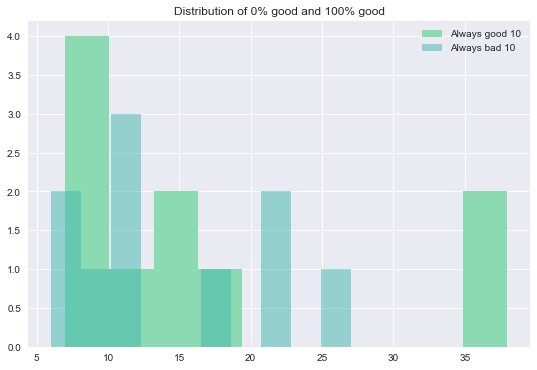

In [898]:
plt.figure(figsize=(9,6))
plt.hist(good.present, alpha=1, label="Always good {}".format(len(good.present)))
plt.hist(bad.present,  alpha=.5, label='Always bad {}'.format(len(bad.present)))
plt.title("Distribution of 0% good and 100% good")
plt.legend(loc='upper right')
plt.show()

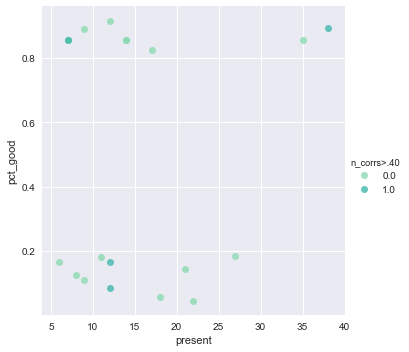

In [893]:
lower_var.sort_values(by='pct_good',ascending=False)
sns.set_palette('mako_r')
sns.lmplot(x='present',y='pct_good',hue='n_corrs>.40', data=lower_var,fit_reg=False)
